# Setup

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns

sns.set_style('ticks')
sns.set_context('notebook')
sns.set(rc={'figure.dpi': 300, 'savefig.dpi': 300})

import matplotlib.pyplot as plt
import matplotlib.colors as clr
# plt.style.use('seaborn-ticks')
plt.style.use('science')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
from graph.data import *
from graph.network import *
from graph.temporal import *
from graph.utils import *

In [3]:
# import graph.data
# import graph.network
# import graph.temporal
# import graph.utils

In [4]:
# import importlib
# importlib.reload(graph.data)
# importlib.reload(graph.network)
# importlib.reload(graph.temporal)
# importlib.reload(graph.utils)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# ! pip install SciencePlots

# Test

In [7]:
l = [1,2,3,4]
l[:3]

[1, 2, 3]

In [8]:
l.extend((4,5))
l

[1, 2, 3, 4, 4, 5]

In [63]:
df = pd.read_csv('/home/ali/Projects/Network/data/phonelab/data/svm_result.csv')

In [66]:
df

,cp,precision,recall,fscore,time
0,1,0.047034,0.047034,0.047034,0.0
1,2,0.077868,0.077868,0.077868,0.0
2,3,0.115756,0.115756,0.115756,0.0
3,5,0.187353,0.187353,0.187353,0.0
4,9,0.213744,0.213744,0.213744,0.0
5,15,0.241181,0.241181,0.241181,0.0
6,22,0.261563,0.261563,0.261563,0.0
7,30,0.276718,0.276718,0.276718,0.0
8,43,0.305461,0.305461,0.305461,0.0
9,62,0.361118,0.361118,0.361118,0.0


Text(0, 0.5, 'SVM Result (e.g. Percision)')

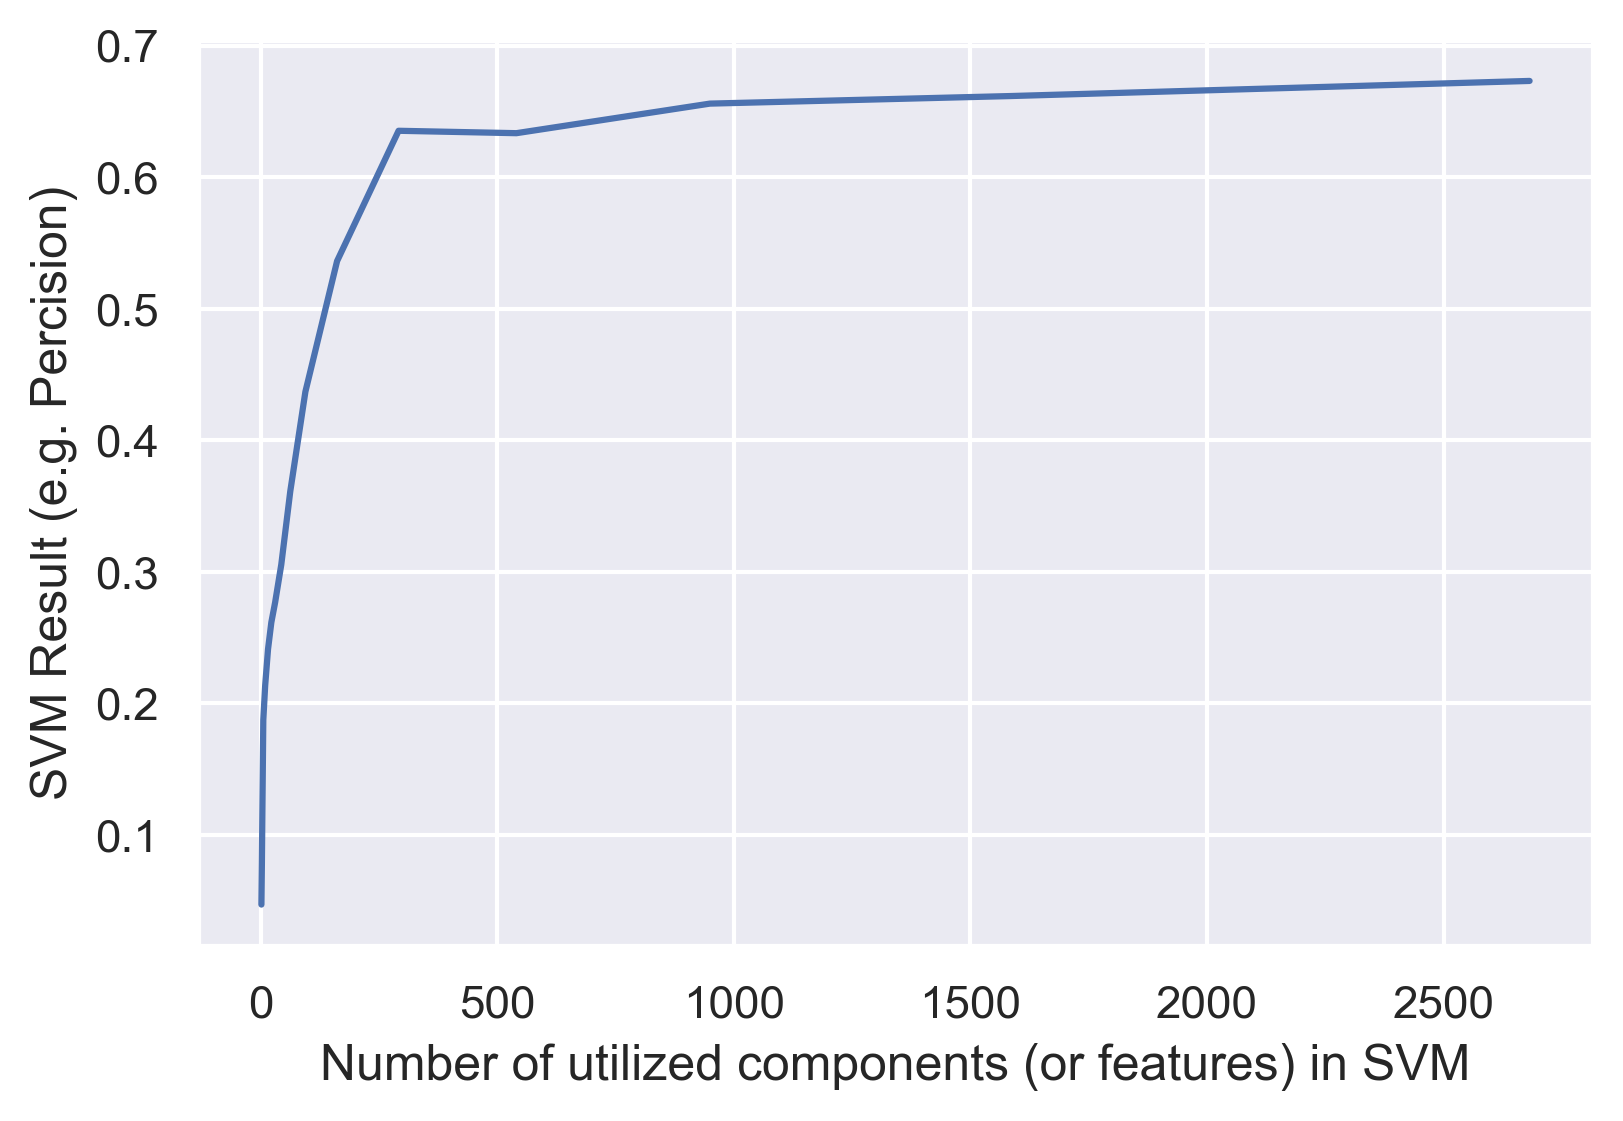

In [70]:
plt.plot(df['cp'],df['precision'])
plt.xlabel('Number of utilized components (or features) in SVM')
plt.ylabel('SVM Result (e.g. Percision)')

# Data

## User-> SSID (Connect)

In [147]:
# M = np.load('/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect.npy')
# sM = sparse.csc_matrix(M)

In [7]:
# sM = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect_sparse.npz')
# M = sM.toarray()

## User @ Day -> SSID (Connect)

In [148]:
# sM = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_day_ssid_connect_sparse.npz')
# M = sM.toarray()

## User -> Location (Connect)

In [8]:
M = np.load('/home/ali/Projects/Network/data/phonelab/data/user_location_connect.npy')
# sM = sparse.csc_matrix(M)

In [162]:
# sM = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_location_connect_sparse.npz')
# M = sM.toarray()

### Analysin connected SSID and users ...

In [9]:
M.shape

(270, 1176)

There are 277 users and 1,176 SSID in connect data

In [10]:
user_dist = np.array(np.sum(M,axis=1,dtype=int).reshape(1,-1))[0]
print(np.where(user_dist == 0)[0])

[]


In [11]:
print(user_dist[:10])
print(list(enumerate(user_dist))[:10])

[240  39 246  76 294  89  32  91  92  69]
[(0, 240), (1, 39), (2, 246), (3, 76), (4, 294), (5, 89), (6, 32), (7, 91), (8, 92), (9, 69)]


This is to check to see if there is any USER that has not been connected to any SSID or visited a location, i.e., if the sum of row (representing a user's data) has no information, which then implies that there has been a bug in code (in fact there was one in earlier version of code) and then if the list is empty we can move on to next step of analysis.

In [169]:
ssid_dist = np.array(np.sum(M,axis=0,dtype=int).reshape(1,-1))[0]
print(np.where(user_dist == 0)[0])

[]


In [204]:
print(ssid_dist[:10])
print(list(enumerate(ssid_dist))[:10])

[  95 9013    2  127    5   46    1  103  366   26]
[(0, 95), (1, 9013), (2, 2), (3, 127), (4, 5), (5, 46), (6, 1), (7, 103), (8, 366), (9, 26)]


Next we sort the SSIDs based on how many time they have been connected to / visited in general (any user could visited same location more than once)

In [205]:
ssid_dist_tuple = sorted(list(enumerate(ssid_dist)), key=lambda e: e[1], reverse=True)
ssid_dist_tuple[:10]

[(1, 9013),
 (43, 1463),
 (72, 992),
 (85, 737),
 (8, 366),
 (133, 293),
 (51, 263),
 (115, 255),
 (242, 241),
 (44, 226)]

Change User-Location matrix in a way that each entry is either 0 or 1    
Thus, we can know how many unique user connected to each SSID

In [207]:
M[M>1]

array([106., 127.,   3., ...,  95.,  66.,   2.])

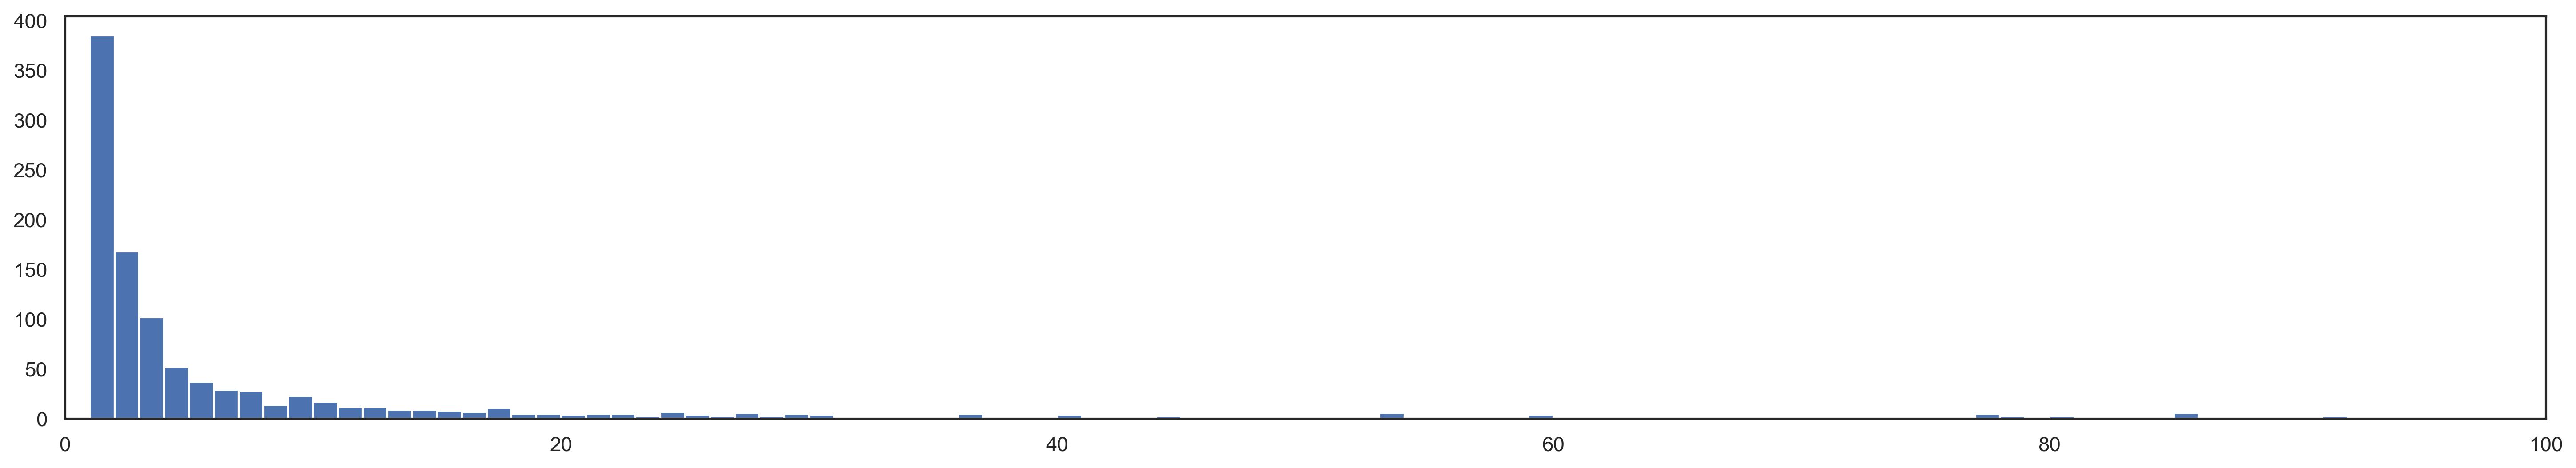

In [199]:
plt.close('all')
fig, ax = plt.subplots(figsize=(24,4))
# ax.hist(user_dist, bins='auto')
# ax.hist(user_dist, bins=range(min(user_dist), max(user_dist) + 1, 10))
ax.hist(ssid_dist, bins=range(min(ssid_dist), max(ssid_dist) + 1, 1))
ax.set_xlim((0,100))
plt.show()

## User @ Day -> Location (Connect)

In [6]:
sM = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_day_location_connect_sparse.npz')
M = sM.toarray()

## User @ Day labels

In [13]:
labels = pd.read_csv(
    # '/home/ali/Projects/Network/data/phonelab/data/user_day_ssid_connect_label.csv',
    '/home/ali/Projects/Network/data/phonelab/data/user_day_location_connect_label.csv',
    index_col=False,
    header=None,
    names=['label']
).astype(int).values

In [14]:
print(len(np.unique(labels)))
print(np.unique(labels))


270
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  76  77  78  79  80  81  82  83  84  85  86  87  88  89  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 165 166
 167 168 169 170 171 172 173 174 175 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 25

## Normalize the matrix (Min-Max)

In [7]:
from sklearn.preprocessing import MaxAbsScaler

In [10]:
min_max_scaler = MaxAbsScaler()
M_scaled = min_max_scaler.fit_transform(M)

In [ ]:
# min_max_scaler = MaxAbsScaler()
# sM_scaled = min_max_scaler.fit_transform(sM)

We have 19,144 rows of data and 1176 SSID or location or 1,176 x 24 = 28,224 (SSID x Hour) spatio-temporal features.

## Standardize the matrix

In [ ]:
# from sklearn.preprocessing import StandardScaler

In [9]:
# standard_scaler = StandardScaler()
# M_scaled= standard_scaler.fit_transform(M)

## Compute covariance matrix
Due to high computation, is executed on CC

In [16]:
# cov_mat = np.cov(M_scaled.T)
# eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

## Load eigen vectors and eigen values

In [75]:
# sE = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect_eigen_vecs_sparse.npz')

# sE = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_day_ssid_connect_eigen_vecs_sparse.npy')

# sE = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_location_connect_eigen_vecs_sparse.npz')

sE = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_day_location_connect_eigen_vecs_sparse.npz')

E = sE.toarray()

FileNotFoundError: [Errno 2] No such file or directory: '/home/ali/Projects/Network/data/phonelab/data/user_day_ssid_connect_eigen_vecs_sparse.npz'

In [73]:
# V = np.load('/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect_eigen_vals.npy')

# V = np.load('/home/ali/Projects/Network/data/phonelab/data/user_day_ssid_connect_eigen_vals.npy')

# V = np.load('/home/ali/Projects/Network/data/phonelab/data/user_location_connect_eigen_vals.npy')

V = np.load('/home/ali/Projects/Network/data/phonelab/data/user_day_location_connect_eigen_vals.npy')

## Variance ratio

Calculate accumulative variance ratio of eigen values

In [13]:
tot = sum(V)
var_exp = np.array([(i / tot) for i in sorted(V, reverse=True)])
cum_var_exp = np.cumsum(var_exp).real

Look at the first 10 pricipal component variance ratio

In [49]:
var_exp[:10].real

array([0.15942093, 0.05406386, 0.02460484, 0.02416157, 0.01292802,
       0.0100606 , 0.00980859, 0.00958766, 0.00916779, 0.00891539])

Look at the first 10 cumilative pricipal component variance ratio

In [48]:
cum_var_exp[:10]

array([0.15942093, 0.21348479, 0.23808964, 0.26225121, 0.27517922,
       0.28523982, 0.29504841, 0.30463607, 0.31380386, 0.32271925])

Find the number of needed components to represent 5,10,15, ... 100 % of data

In [19]:
split_at = cum_var_exp.searchsorted(np.linspace(0,1,20,endpoint=False))

In [22]:
ll = np.linspace(0,1,20,endpoint=False)
print(ll)
print(ll[len(ll)-3::-1])

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]
[0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3  0.25 0.2
 0.15 0.1  0.05 0.  ]


In [47]:
split_at

array([  0,   0,   0,   0,   1,   3,   7,  13,  21,  30,  42,  54,  67,
        81,  97, 116, 140, 178, 245, 385])

Number of components -> ratio

In [27]:
for pc, ratio in zip(split_at + 1, np.round(np.linspace(0, 1, 20, endpoint=False), 2)):
    print(f'{pc} -> {ratio}')

1 -> 0.0
1 -> 0.05
1 -> 0.1
1 -> 0.15
2 -> 0.2
4 -> 0.25
8 -> 0.3
14 -> 0.35
22 -> 0.4
31 -> 0.45
43 -> 0.5
55 -> 0.55
68 -> 0.6
82 -> 0.65
98 -> 0.7
117 -> 0.75
141 -> 0.8
179 -> 0.85
246 -> 0.9
386 -> 0.95


In [33]:
print(f'80 % of data can be captured using {split_at[-4] + 1} number of components or {np.round((split_at[-4] + 1) / len(V) * 100, 2)} % of features.')

80 % of data can be captured using 141 number of components or 11.99 % of features.


Exclude repeated ones because they are give us same number of components

In [45]:
split_at[3:]

array([  0,   1,   3,   7,  13,  21,  30,  42,  54,  67,  81,  97, 116,
       140, 178, 245, 385])

Check the variance ration at the identified component numbers    
Note they should be increasing within 5% ratio ...

In [46]:
cum_var_exp[split_at][3:]

array([0.15942093, 0.21348479, 0.26225121, 0.30463607, 0.35384547,
       0.40276406, 0.45046497, 0.50390473, 0.55290344, 0.60222892,
       0.65109451, 0.70105646, 0.75236496, 0.80125203, 0.85052335,
       0.9000494 , 0.9501185 ])

## Visualize variance ratio

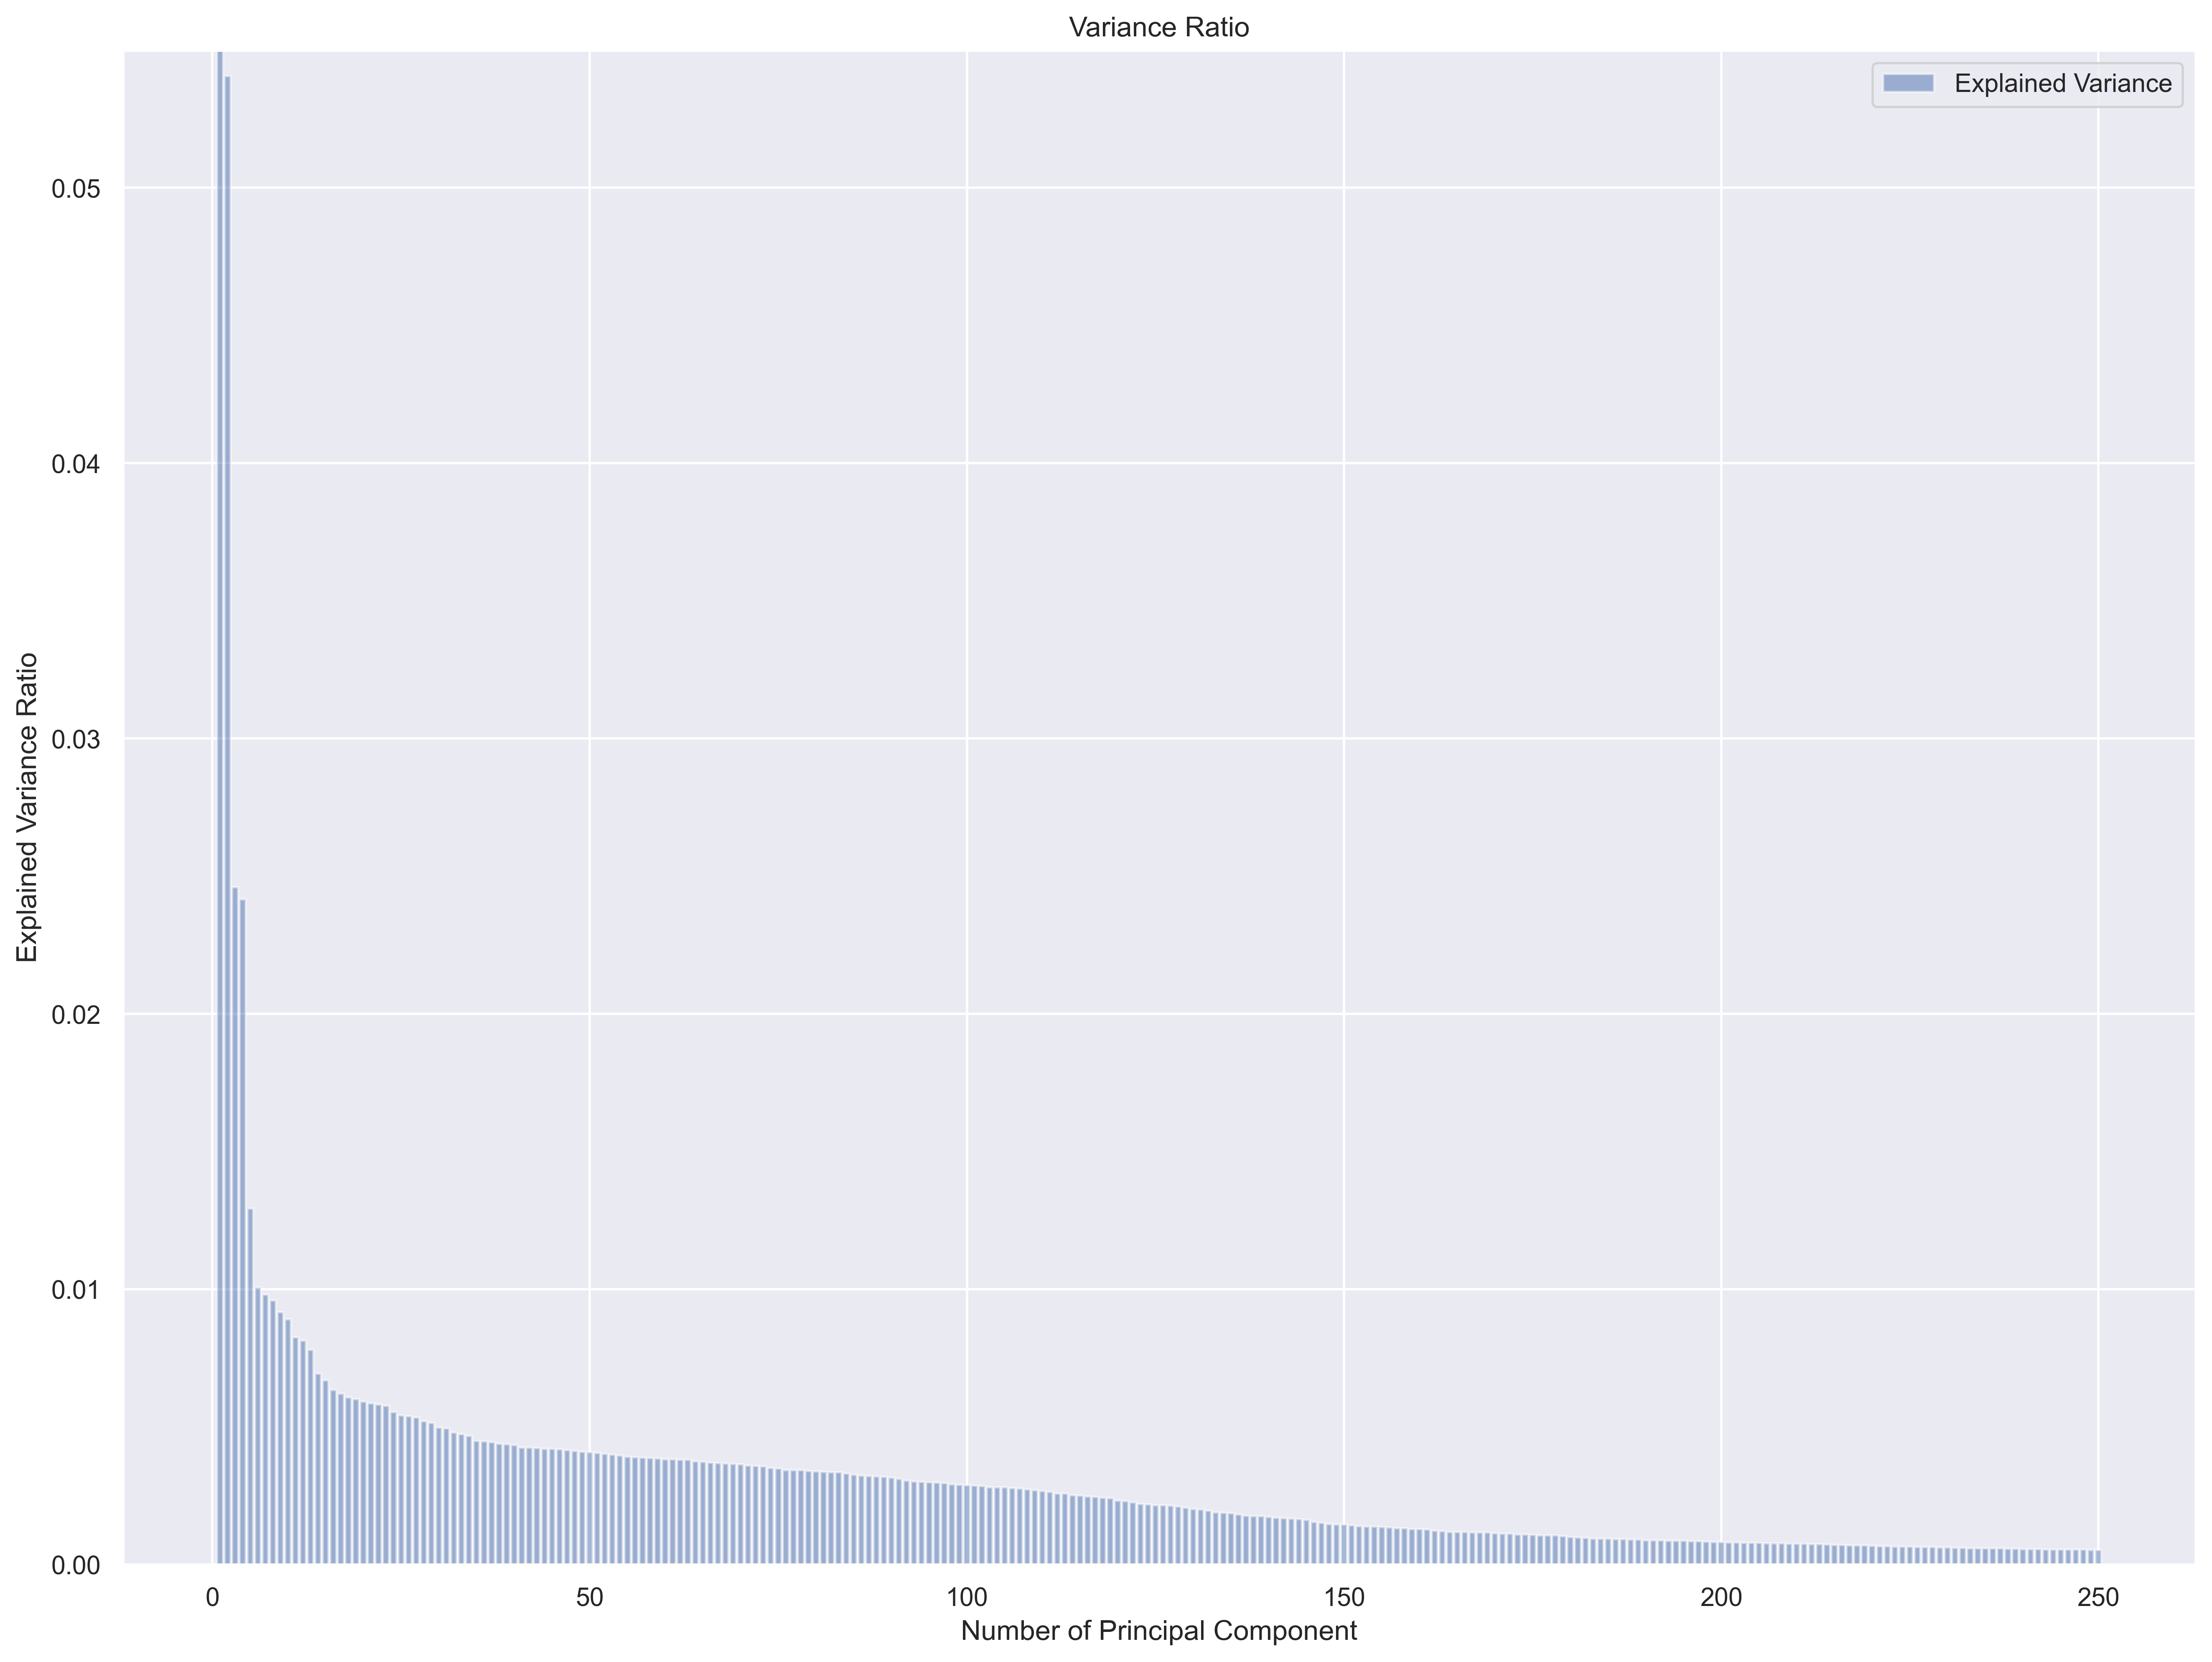

In [54]:
plt.figure(figsize=(16, 12), dpi=400)
plt.bar(
        # range(1, len(V) + 1),
        # var_exp.real,
        range(1, 251),
        var_exp[:250].real,
        alpha=0.5,
        align='center',
        label='Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Component')
plt.legend(loc='best')
PATH = os.path.join(DATA, 'pca_variance_ratio.pdf')
# plt.savefig(PATH, dpi=400)
plt.ylim((0,0.055))
plt.title('Variance Ratio')
plt.show()

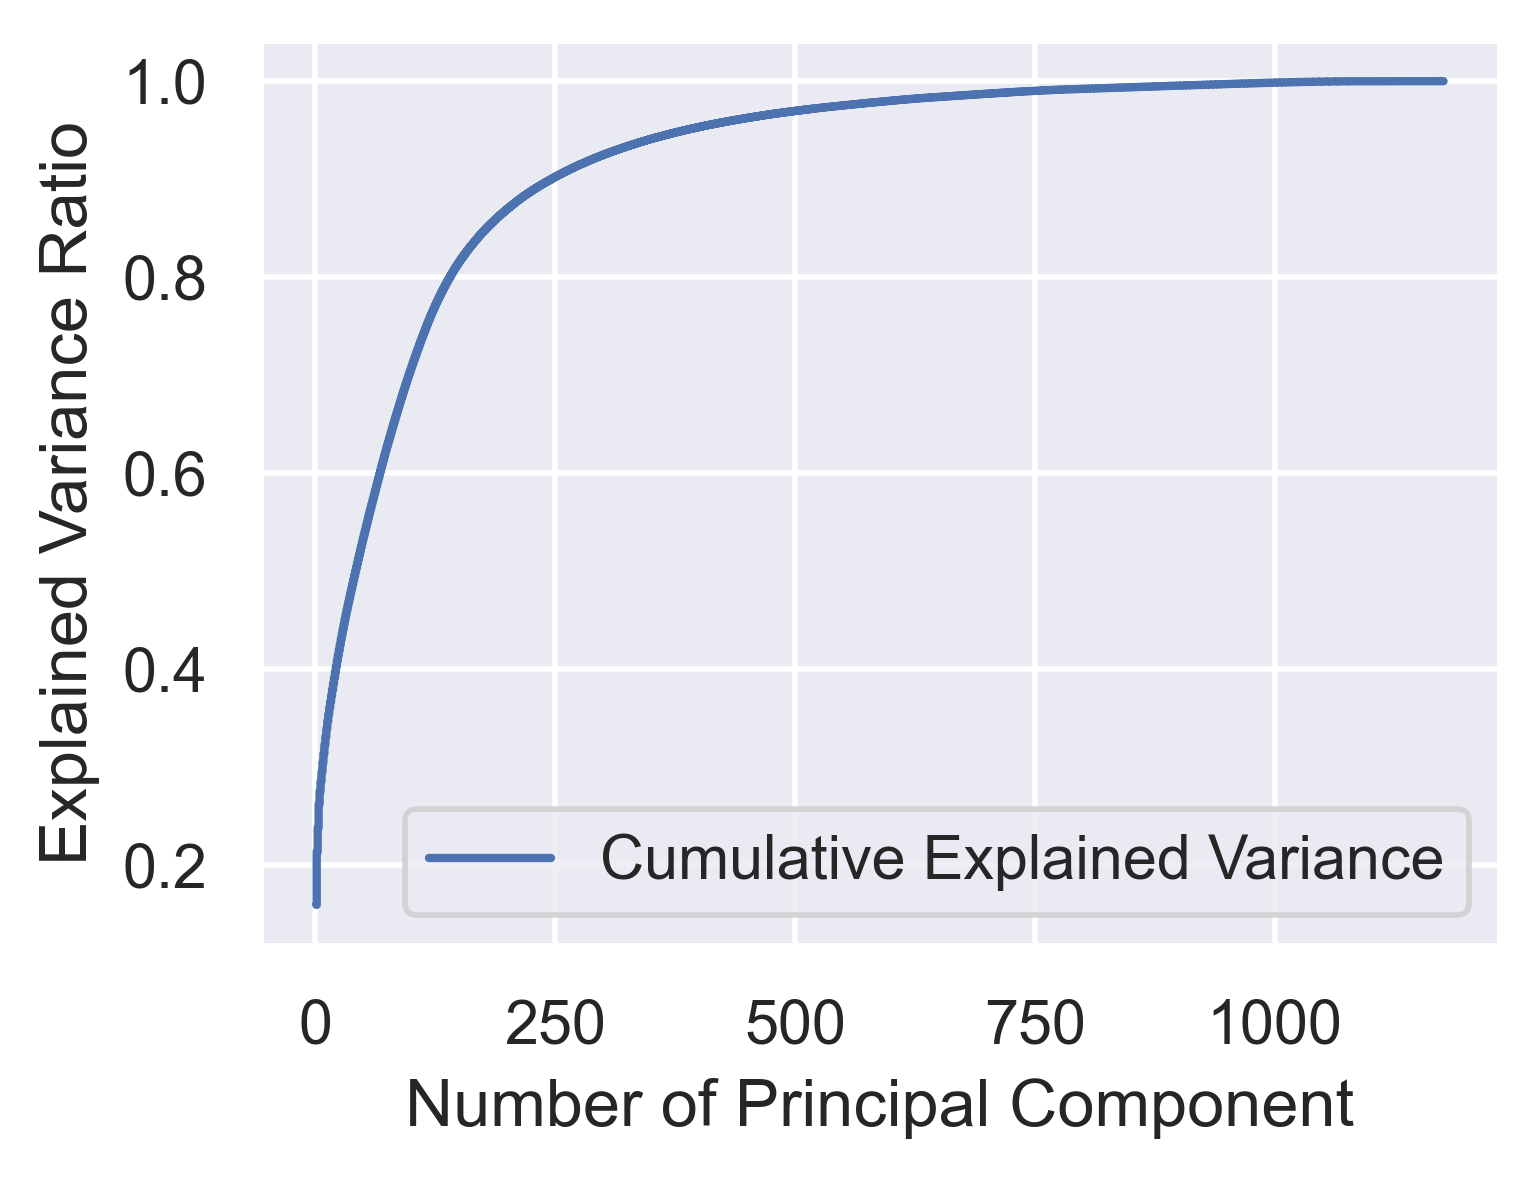

In [59]:
plt.figure(figsize=(4, 3), dpi=400)
plt.step(
            range(1, len(V) + 1),
            cum_var_exp.real,
            # range(1, 1051),
            # cum_var_exp[0:1050].real,
            where='mid',
            label='Cumulative Explained Variance')
# plt.plot(cum_var_exp)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Component')
plt.legend(loc='best')
PATH = os.path.join(DATA, 'pca_variance_ratio.pdf')
# plt.savefig(PATH, dpi=400)
plt.show()

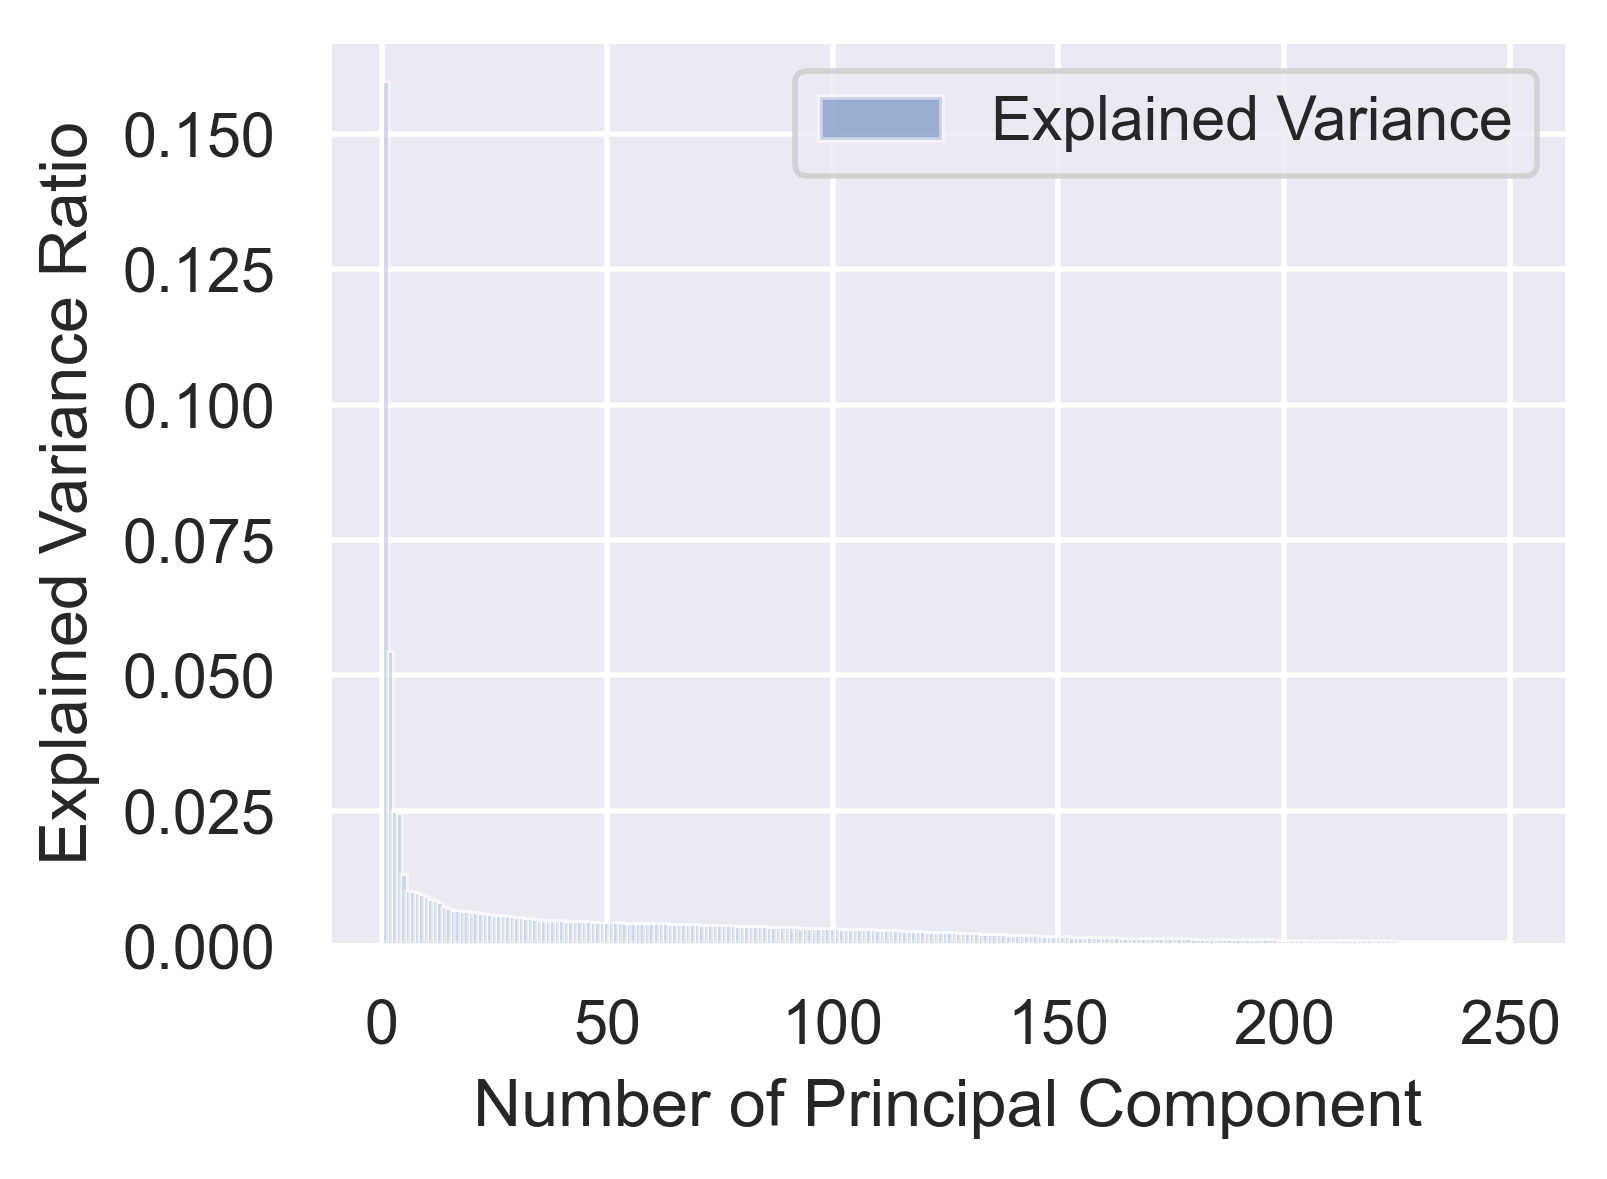

In [60]:
plt.figure(figsize=(4, 3), dpi=400)
plt.bar(range(1, 251),
        var_exp[:250].real,
        alpha=0.5,
        align='center',
        label='Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Component')
plt.legend(loc='best')
PATH = os.path.join(DATA, 'pca_variance_ratio.pdf')
# plt.savefig(PATH, dpi=400)
plt.show()

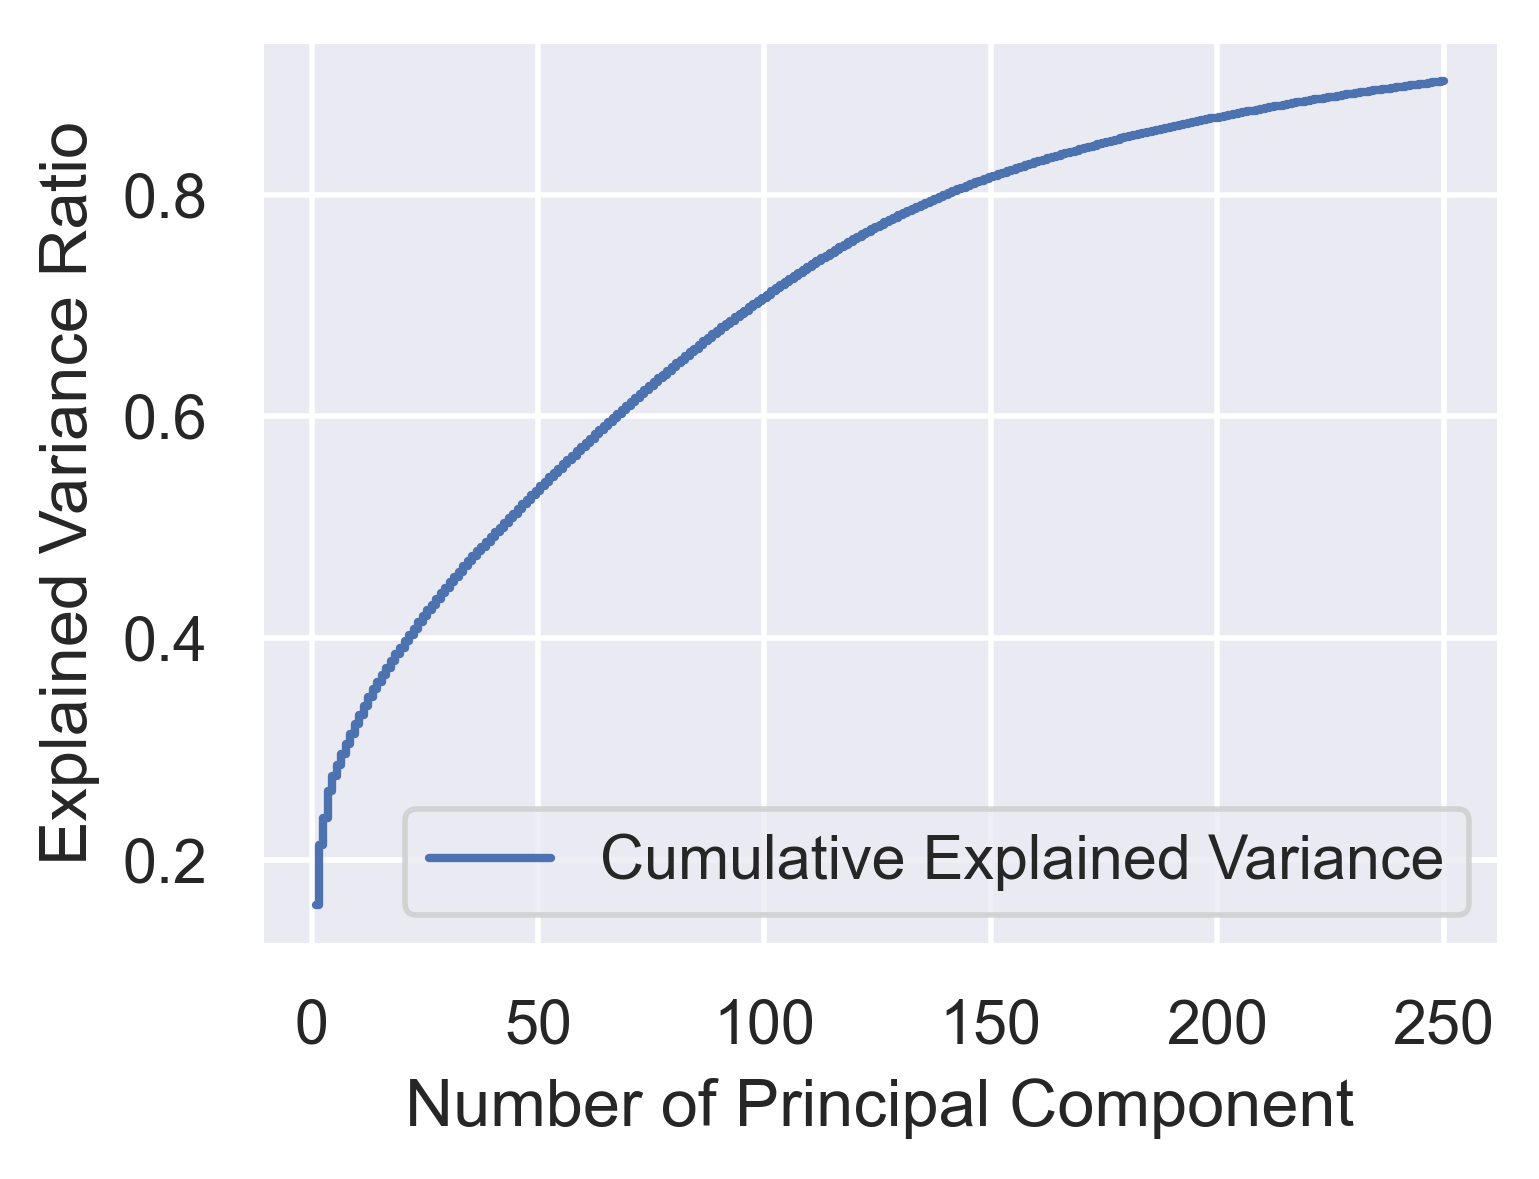

In [61]:
plt.figure(figsize=(4, 3), dpi=400)
plt.step(range(1, 251),
            cum_var_exp[0:250].real,
            where='mid',
            label='Cumulative Explained Variance')
# plt.plot(cum_var_exp)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Component')
plt.legend(loc='best')
PATH = os.path.join(DATA, 'pca_variance_ratio.pdf')
# plt.savefig(PATH, dpi=400)
plt.show()

## Sort eigen vectors and eigen values

In [26]:
eigen_pairs = [(np.abs(V[i]), E[:, i]) for i in range(len(V))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [40]:
# idx = eigen_vals.argsort()[::-1]   
# eigen_vals = eigen_vals[idx]
# eigen_vecs = eigen_vecs[:,idx]
# eigen_pairs = (eigen_vals, eigen_vecs)

In [29]:
component_number = 250
W = np.concatenate(
    [eigen_pairs[i][1][:, np.newaxis] for i in range(component_number)],
    axis=1
)

In [30]:
W.shape

(28224, 250)

In [31]:
# M_new = np.dot(M_minmax, W)
M_new = M_minmax @ W

# file_name = f'/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect_transformed_{component_number}.npy'
# np.save(file_name, M_new)

In [ ]:
M_new.shape

Error: Kernel is dead

In [5]:
PATH = '/home/ali/Projects/Network/data/phonelab/data/user_day_ssid_connect_label.csv'
M_labels = pd.read_csv(PATH, index_col=False, header=None, names=['label']).iloc[:, 0]
# y = pd.read_csv(PATH, index_col=False, header=None, names=['label']).astype(int).values

Calculate the distribution of classes

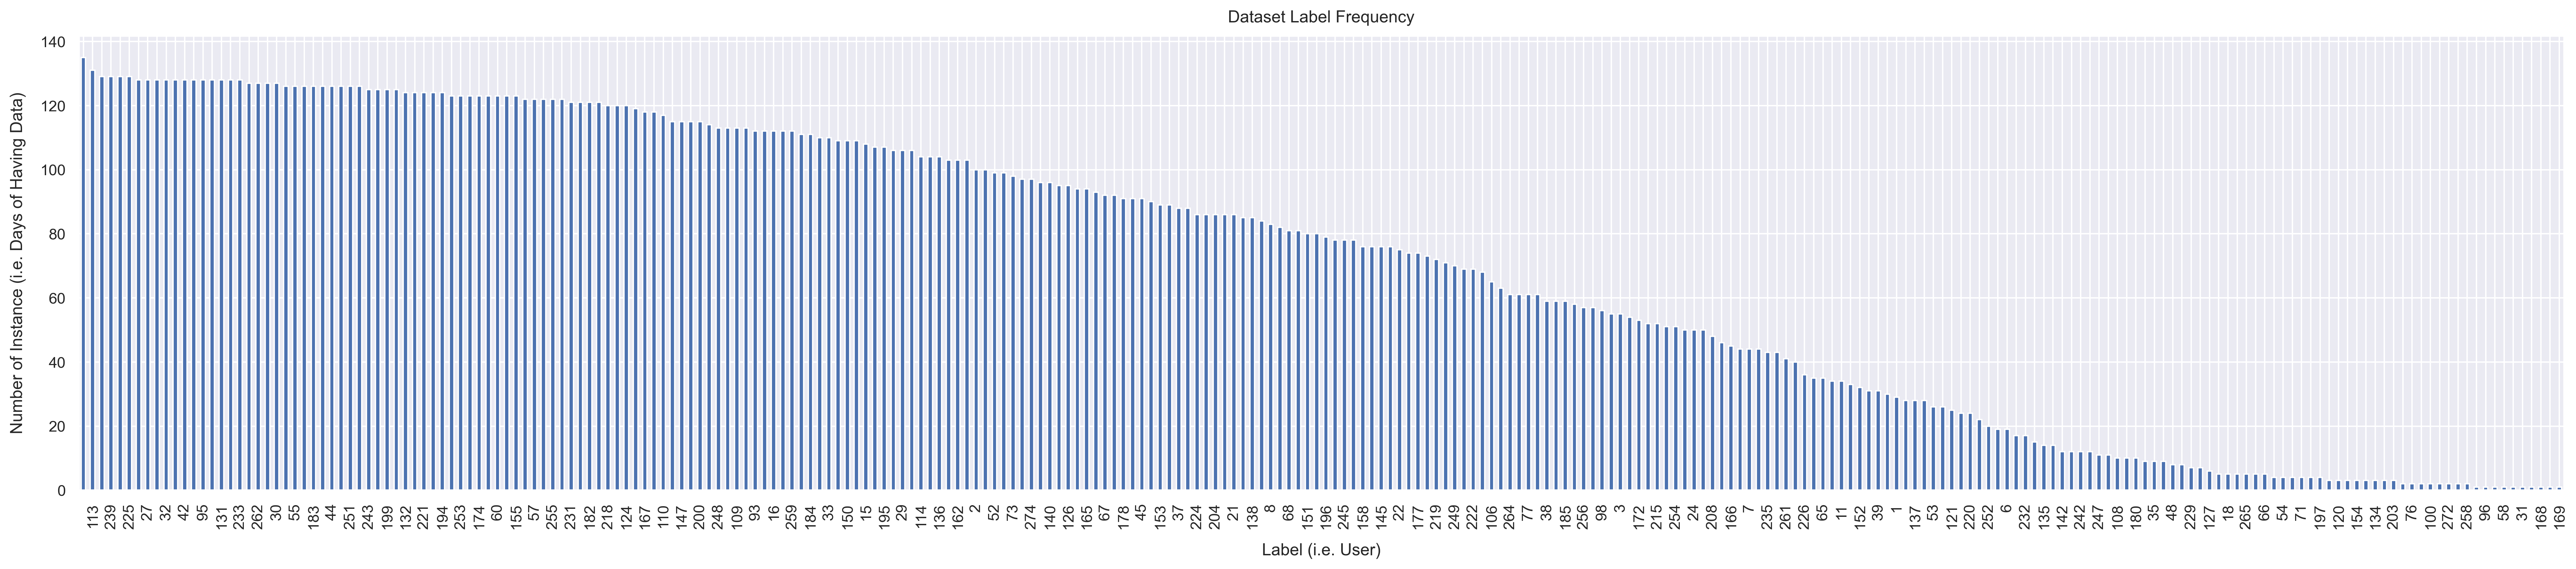

In [242]:
M_labels.value_counts().plot(kind='bar', figsize=(32, 6), rot=90)
# plt.xticks(rotation=90)
# Remoce odd X ticks
ax=plt.gca()
for label in ax.get_xaxis().get_ticklabels()[::2]:
    label.set_visible(False)
plt.xlabel('Label (i.e. User)', labelpad=10)
plt.ylabel('Number of Instance (i.e. Days of Having Data)', labelpad=10)
plt.title('Dataset Label Frequency', pad=10);

In [38]:
my_cmap = clr.LinearSegmentedColormap.from_list('my_cmap',[(0, 'skyblue'),(0.25, 'aqua'),(0.5, 'royalblue'),(0.75, 'darkblue'),(1, 'black')],N=len(M_labels.unique()))

In [54]:
my_cmap = sns.color_palette('rocket',n_colors=len(M_labels.unique()),as_cmap=True)

In [156]:
def discrete_cmap(N, base_cmap=None):
    '''Create an N-bin discrete colormap from the specified input map'''

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

/home/ali/Anaconda/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


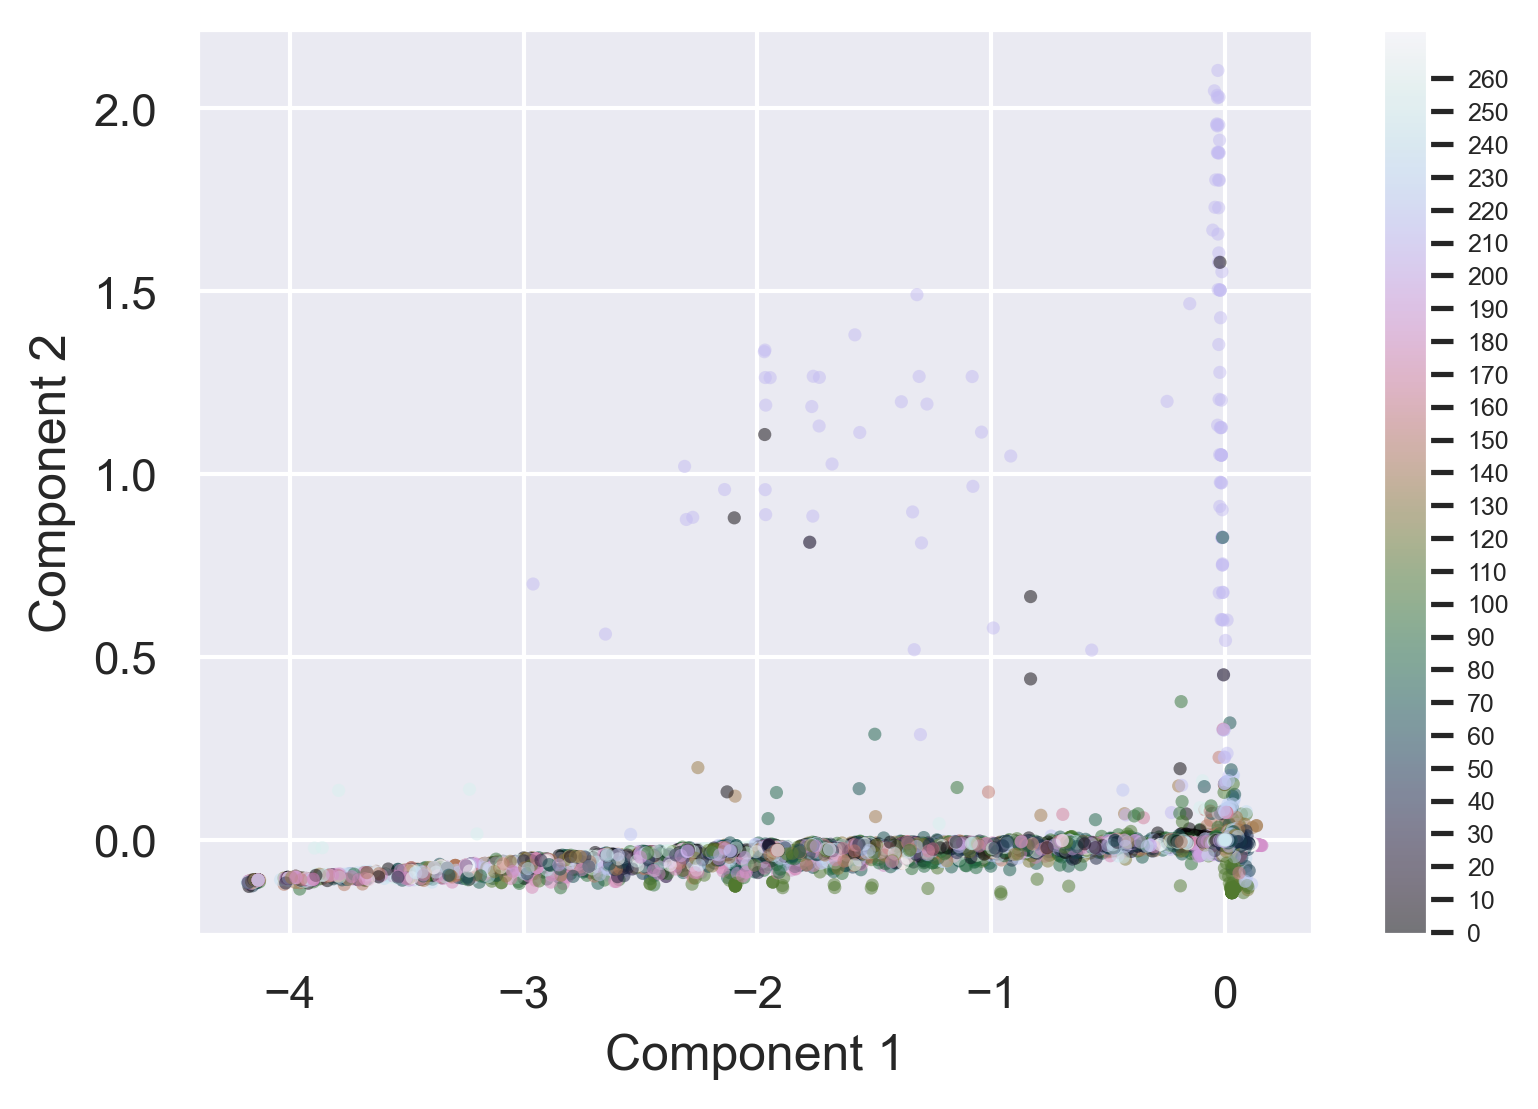

In [163]:
N = len(M_labels.unique())
plt.scatter(
    M_new[:, 0],
    M_new[:, 1],
    c=M_labels,
    edgecolor='none',
    alpha=0.5,
    s=10,
    # cmap=plt.cm.get_cmap('spectral', 10) # Only if we have 10 classes
    # cmap=plt.cm.get_cmap('viridis')
    cmap = discrete_cmap(N, 'cubehelix')
    # cmap = my_cmap
)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
# plt.colorbar()
cbar = plt.colorbar(ticks=range(0,N,10))
cbar.ax.tick_params(labelsize=6)

In [68]:
df = pd.DataFrame(np.concatenate((M_new.real, M_labels[:, np.newaxis]), axis=1),columns=['cp1','cp2','label'])

/tmp/ipykernel_681549/1392924346.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = pd.DataFrame(np.concatenate((M_new.real, M_labels[:, np.newaxis]), axis=1),columns=['cp1','cp2','label'])


# Clustering on Dataset After PCA

Let's create dataframe from transformed data after PCA

In [262]:
df = pd.DataFrame(
    data=M_new.real, columns=['pc' + str(i) for i in range(M_new.shape[1])]
)
df['target'] = M_labels.astype(int)

In [263]:
df.head()

,pc0,pc1,target
0,-0.186998,-0.011642,245
1,-0.408995,-0.020289,245
2,-0.021339,-0.001319,20
3,-0.004186,-0.001234,107
4,0.019179,-0.017072,245


A few of classes (i.e. labels) has only 1 instance which could affect the prediction. So we can (optionally) remove these to improve the classification

In [264]:
M_labels_counts = df['target'].value_counts()
print(M_labels_counts[M_labels_counts < 2].index)

df.drop(
    df[df['target'].isin(M_labels_counts[M_labels_counts < 2].index)].index,
    inplace=True
)

# M_labels_counts = df['target'].value_counts()
# print(M_labels_counts[M_labels_counts < 2].index)

Int64Index([13, 96, 263, 58, 84, 31, 91, 168, 266, 169], dtype='int64')
Int64Index([], dtype='int64')


Split dataset into training and test sets (while considering distribution of classes)

In [269]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    df, test_size=0.2, random_state=1, stratify=df['target']
)

# print(train_set['target'].value_counts() / len(train_set))
# print(test_set['target'].value_counts() / len(test_set))

Another way of dataset split

In [268]:
# from sklearn.model_selection import StratifiedShuffleSplit

# strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
# for train_index, test_index in strat_split.split(df, df['target']):
#     train_set = df.iloc[train_index]
#     test_set = df.iloc[test_index]

# print(train_set['target'].value_counts() / len(train_set))
# print(test_set['target'].value_counts() / len(test_set))

81     0.007056
113    0.006860
239    0.006729
111    0.006729
46     0.006729
         ...   
23     0.000131
179    0.000131
133    0.000131
227    0.000131
76     0.000131
Name: target, Length: 260, dtype: float64
81     0.007055
233    0.006794
113    0.006794
46     0.006794
0      0.006794
         ...   
82     0.000261
12     0.000261
156    0.000261
133    0.000261
203    0.000261
Name: target, Length: 246, dtype: float64


print(df.shape)

In [183]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [184]:
x_train = train_set.iloc[:,:-1]
y_train = train_set.iloc[:,-1]
x_test = test_set.iloc[:,:-1]
y_test = test_set.iloc[:,-1]

In [185]:
x_train.head()

,cp1,cp2
10156,-0.554097,0.054855
8513,-3.736832,-0.103741
9827,-0.843864,-0.035939
13999,0.002857,-0.000319
14317,-1.731069,-0.064939


In [194]:
print(x_test.iloc[0].values.reshape(1, -1))
print(y_test.iloc[0])

[[-1.03403381 -0.02710742]]
65


## SVM

In [187]:
from sklearn.svm import SVC

In [188]:
svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(x_train, y_train)

SVC(gamma='auto', random_state=42)

In [13]:
svm_clf.predict(x_test.iloc[0].values.reshape(1, -1))

NameError: name 'svm_clf' is not defined

In [167]:
from sklearn.ensemble import RandomForestClassifier

# classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = RandomForestClassifier(max_depth=20, random_state=0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

In [168]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[17  0  0 ...  0  0  0]
 [ 0  6  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  4  1]
 [ 0  0  0 ...  0  0  6]]
0.4570383912248629


In [152]:
N = len(M_labels.unique())
base = plt.cm.get_cmap('cubehelix')
color_list = base(np.linspace(0, 1, N))
# print(color_list)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='randomized')

# M_new = pca.fit_transform(M)
M_new = pca.fit_transform(M_minmax)

print(pca.components_.shape)
print(pca.explained_variance_ratio_)

/home/ali/Anaconda/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


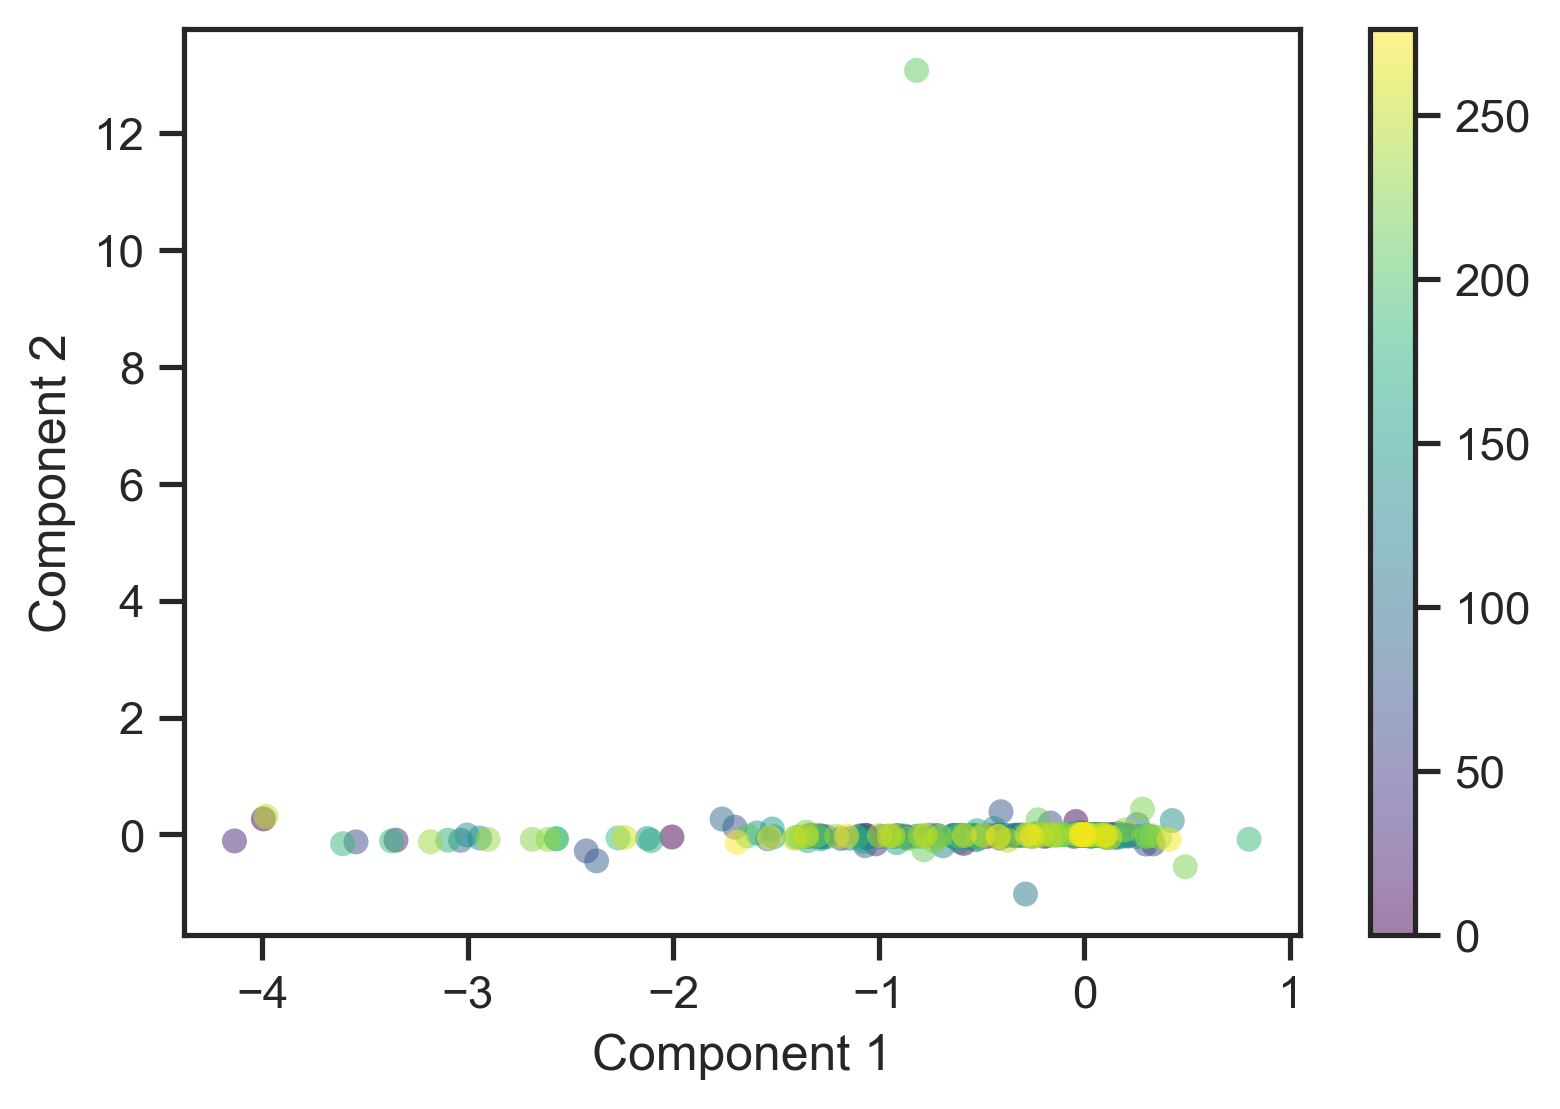

In [52]:
target = np.arange(0, M_new.shape[0])
plt.scatter(
    M_new[:, 0],
    M_new[:, 1],
    c=target,
    edgecolor='none',
    alpha=0.5,
    # cmap=plt.cm.get_cmap('spectral', 10) # Only if we have 10 classes
    cmap=plt.cm.get_cmap('viridis')
)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()

In [53]:
principalDf = pd.DataFrame(
    data=M_new, columns=['pc1', 'pc2']
)

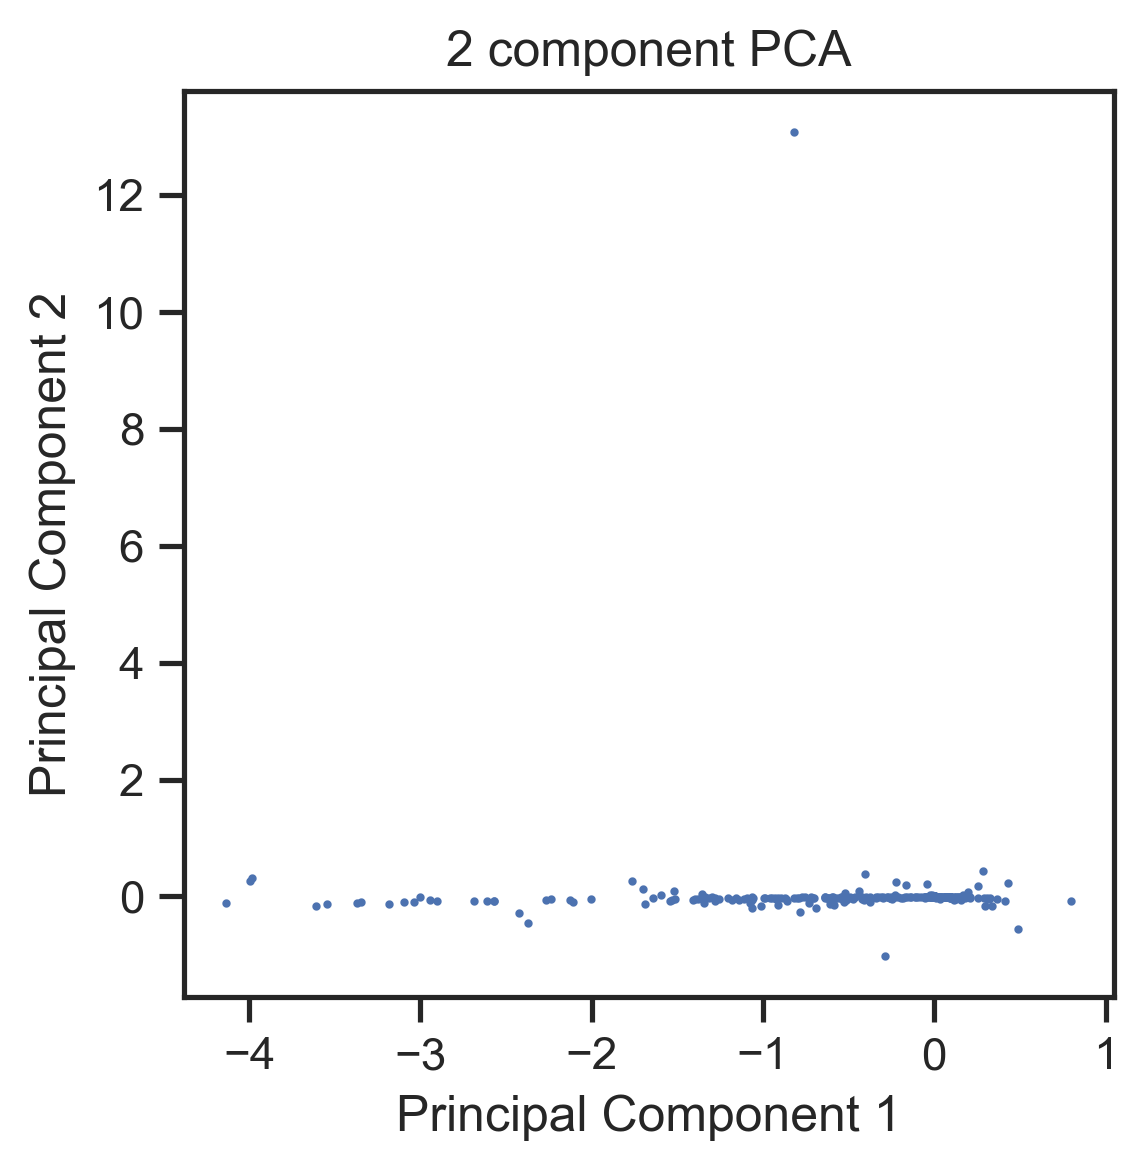

In [54]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA')
# ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(
    principalDf['pc1'],
    principalDf['pc2'],
    s=1
)
# ax.grid()

In [68]:
pca = PCA().fit(M_minmax.T)

In [86]:
pca.explained_variance_ratio_.shape

(277,)

In [ ]:
pca_com = []
pca_var = []
for dim in np.arange(1, M_minmax.shape[0]):
    if dim <= M_minmax.shape[0]:
        svd_solver = 'full'
    else:
        svd_solver = 'randomized'
    pca = PCA(n_components=dim, svd_solver=svd_solver).fit(M_minmax)
    pca_com.append(dim)
    pca_var.append(sum(pca.explained_variance_ratio_))
plt.plot(pca_com, pca_var)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Text(0, 0.5, 'Cumulative explained variance')

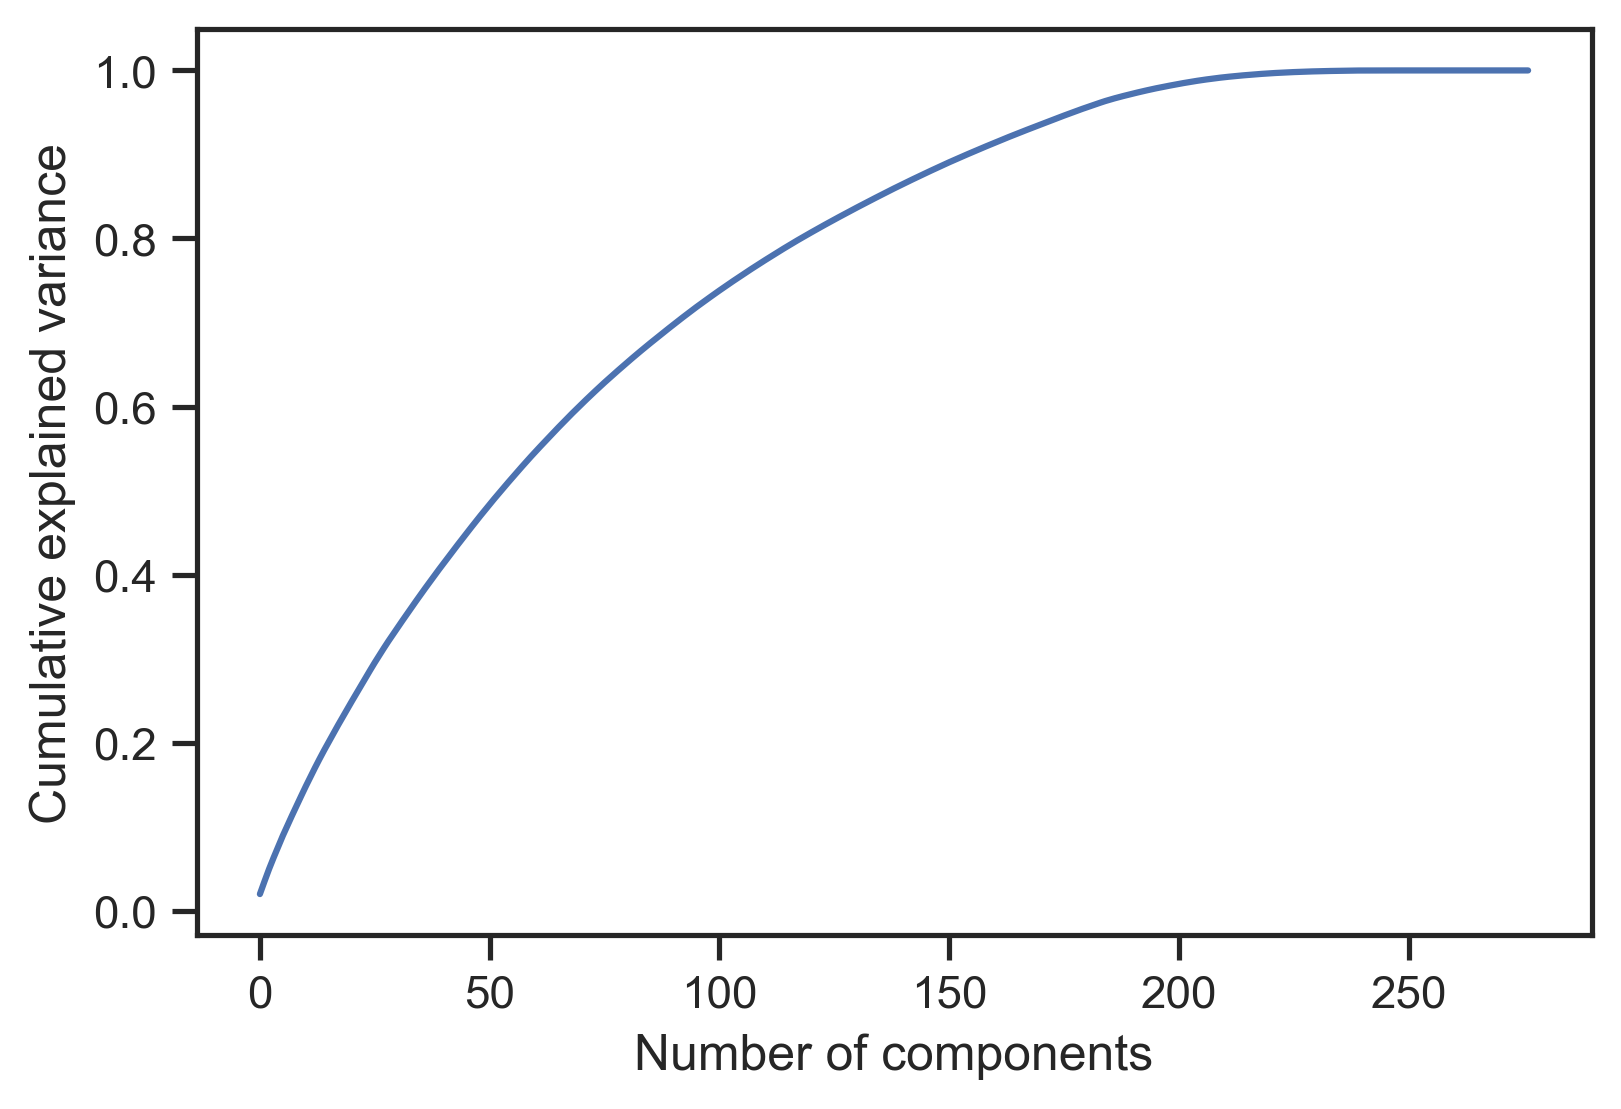

In [87]:
pca = PCA().fit(M_minmax)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')